Current working directory: c:\Users\nizar\Desktop\spring 2025\CSC 59866\Main Lecture\HW2
Attempting to load CSV file from: c:\Users\nizar\Desktop\spring 2025\CSC 59866\Main Lecture\HW2\winequality-white.csv


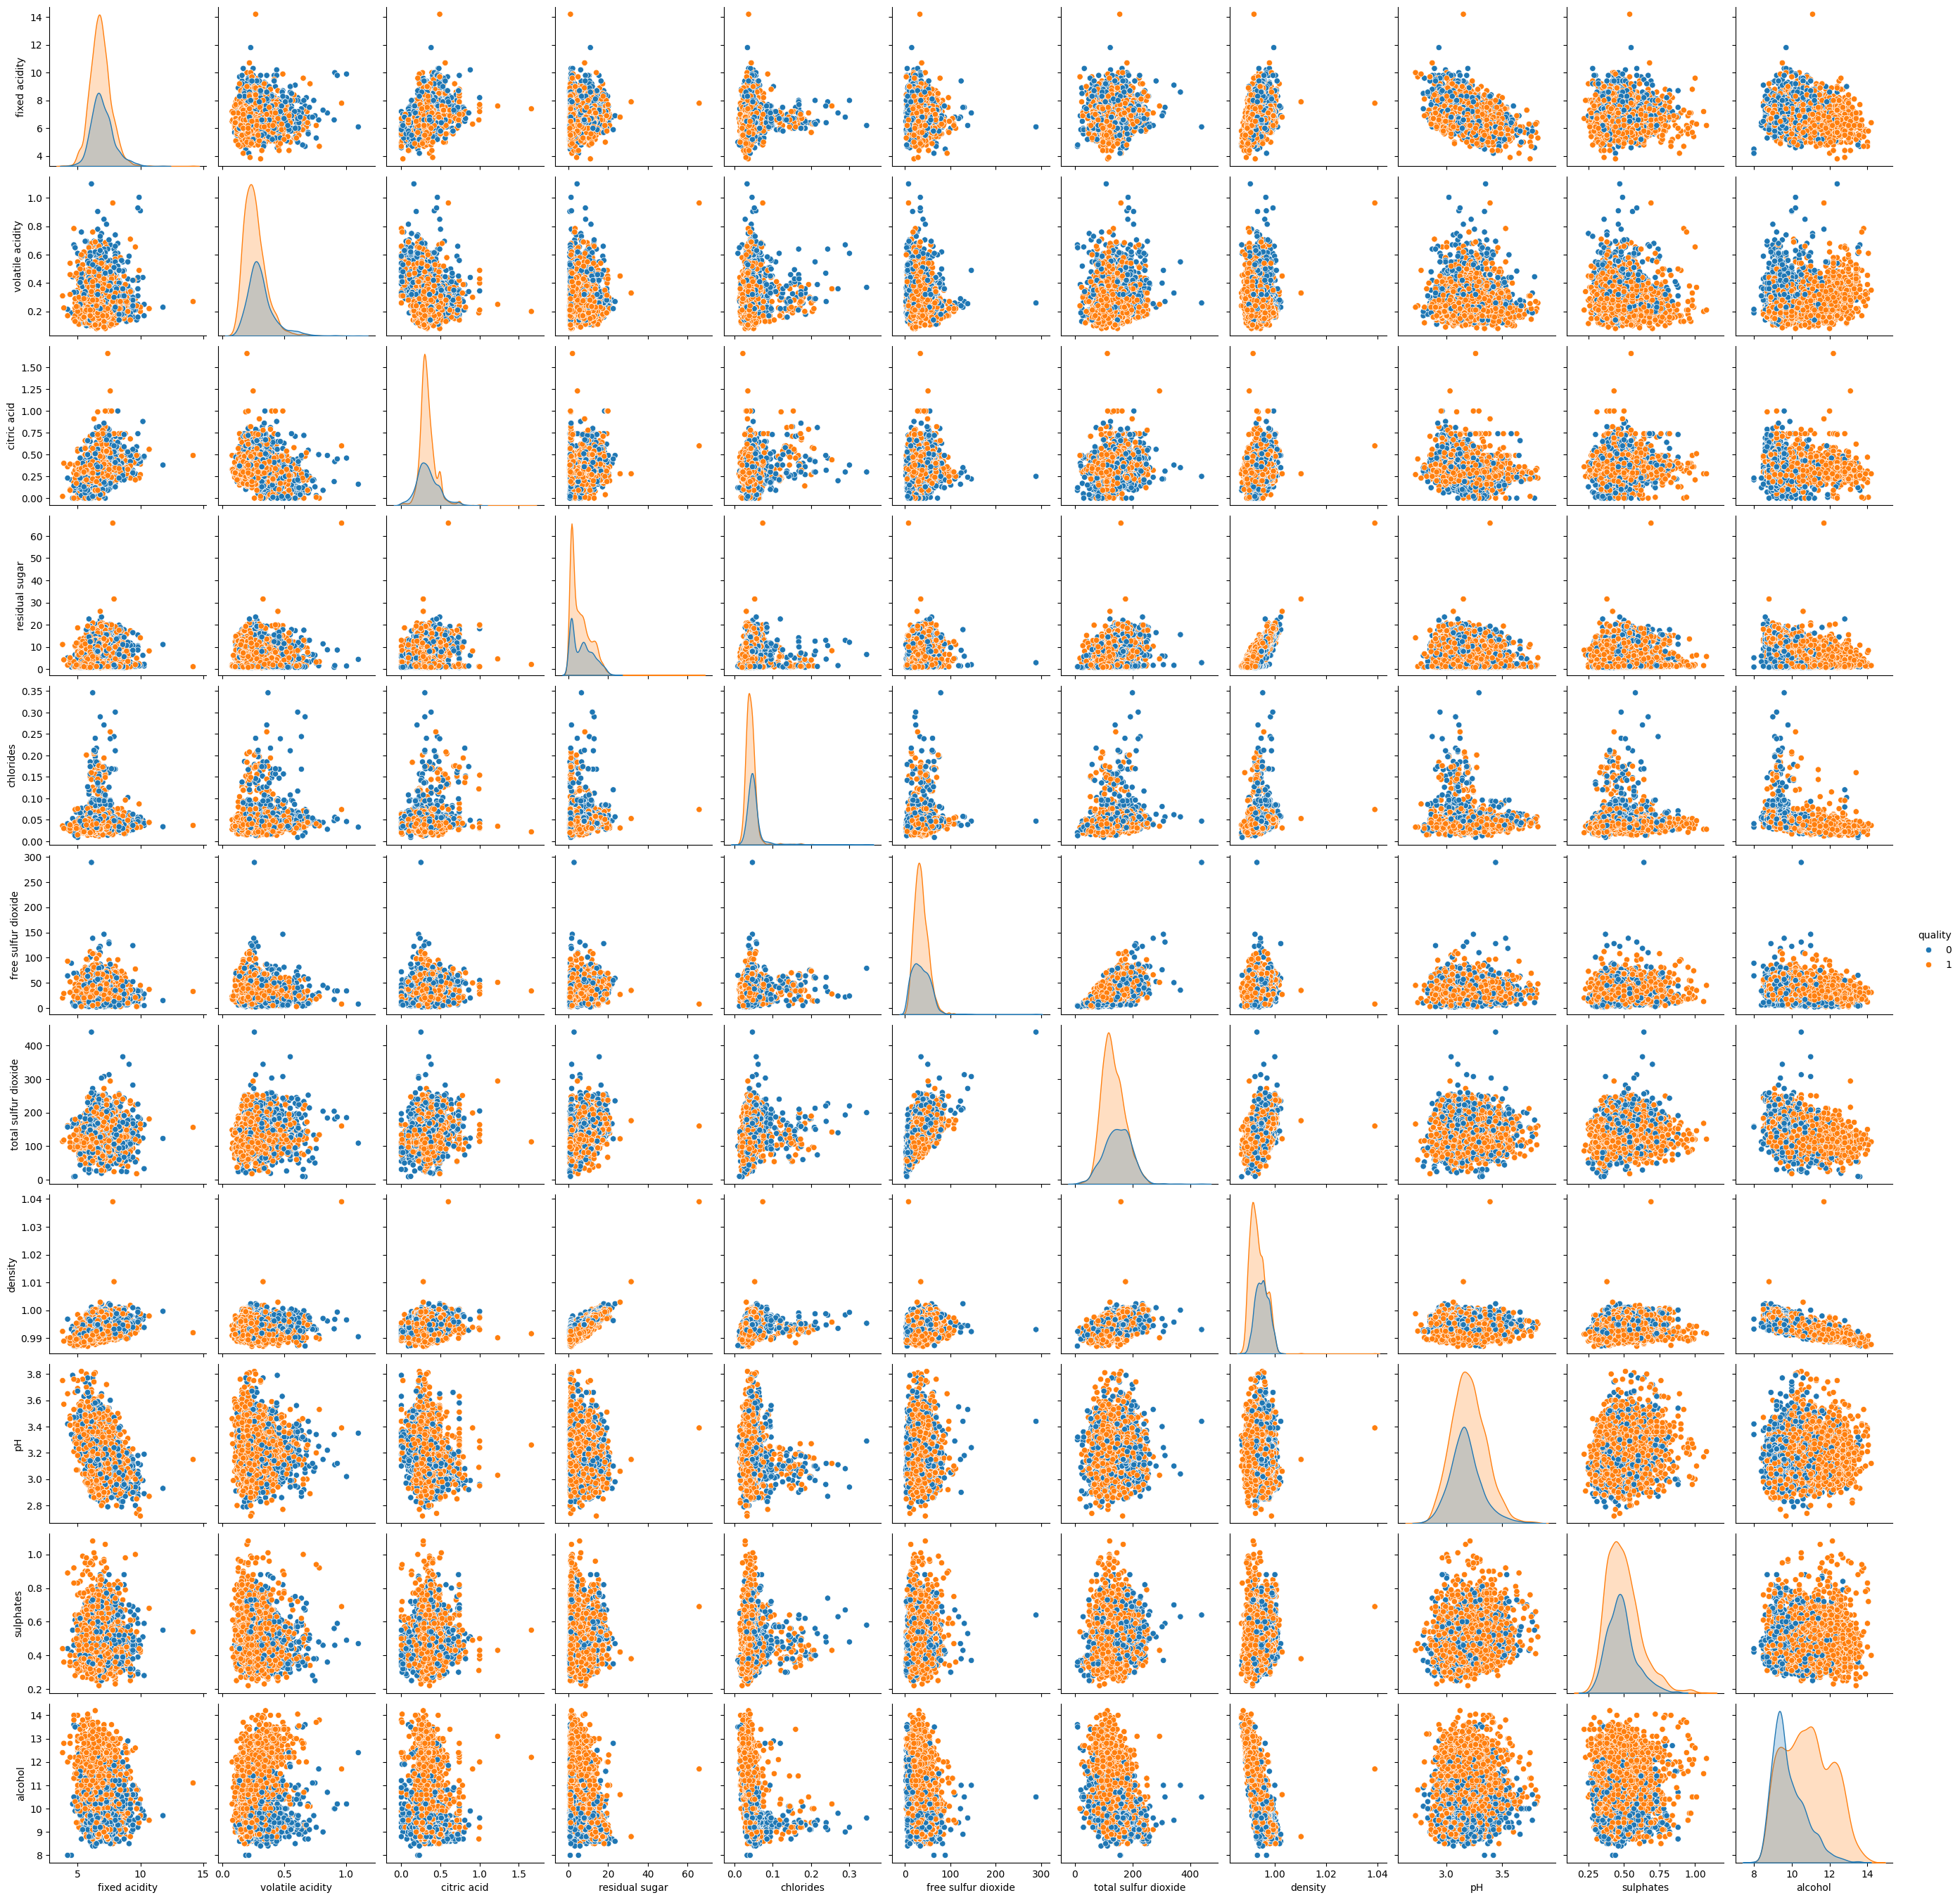

     k Distance Metric Weighting  Accuracy  F1 Score
7    5       manhattan  distance  0.835714  0.879220
13  11       euclidean  distance  0.834694  0.880707
15  11       manhattan  distance  0.833673  0.878810
9    9       euclidean  distance  0.831633  0.877506
11   9       manhattan  distance  0.826531  0.873512
5    5       euclidean  distance  0.823469  0.870218
3    1       manhattan  distance  0.809184  0.858868
2    1       manhattan   uniform  0.809184  0.858868
1    1       euclidean  distance  0.804082  0.854545
0    1       euclidean   uniform  0.804082  0.854545
6    5       manhattan   uniform  0.780612  0.840386
12  11       euclidean   uniform  0.769388  0.835756
4    5       euclidean   uniform  0.760204  0.825538
8    9       euclidean   uniform  0.760204  0.828342
14  11       manhattan   uniform  0.757143  0.825513
10   9       manhattan   uniform  0.754082  0.822924
Selected best hyperparameters: k=5, Distance Metric=manhattan, Weighting=distance
Final Model Perfo

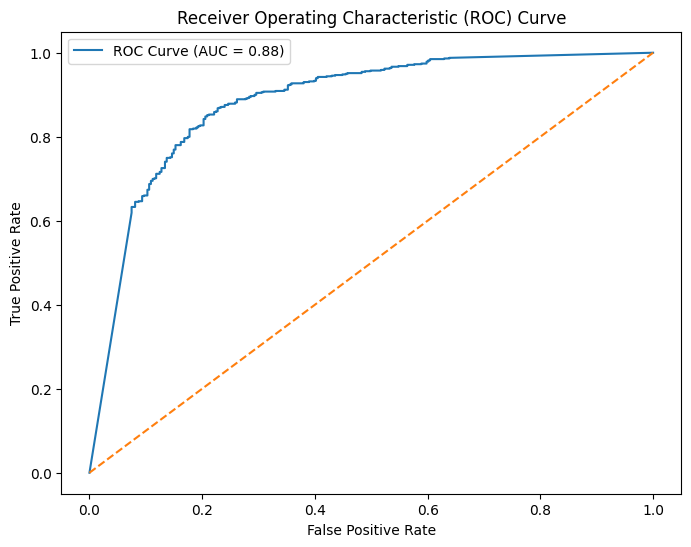

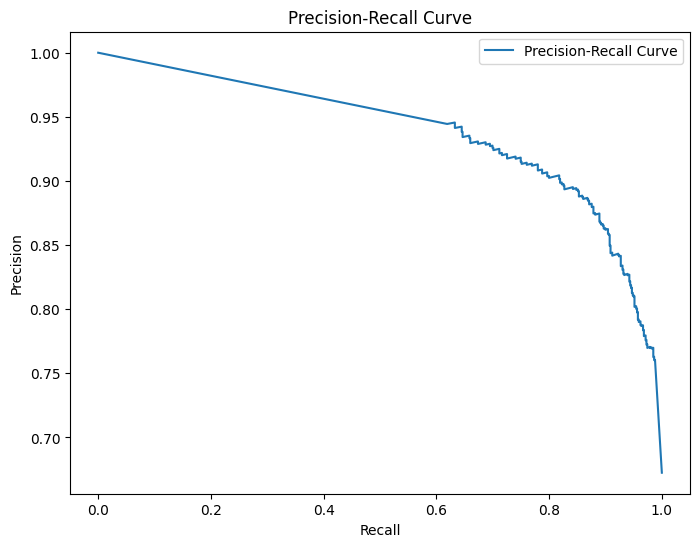

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)

# Build the file path based on the current working directory. Did this so it is easier for someone else to run my code
file_path = os.path.join(os.getcwd(), "winequality-white.csv")

# print them out to help verify. I was having trouble running it from another location
print("Current working directory:", os.getcwd())
print("Attempting to load CSV file from:", file_path)

# Load the wine quality dataset.
# The CSV file uses a semicolon as the separator.
wine_data = pd.read_csv(file_path, delimiter=';')

# Now, onvert the quality ratings to a binary format:
# If the quality is greater than 5, consider it "good" (1); otherwise "not good" (0).
wine_data['quality'] = wine_data['quality'].apply(lambda x: 1 if x > 5 else 0)

# Create a pairplot to see the relationships among features.
# The 'hue' parameter was used to color the data based on the binary quality label.
sns.pairplot(wine_data, hue="quality")
plt.show()

# Here we are defining a helper function to split the data into training and test sets.
def split_dataset(features, labels, test_ratio=0.2):
    """
    Splits features and labels into training and testing subsets.

    Parameters:
        features (DataFrame): The input features.
        labels (Series): The target labels.
        test_ratio (float): The fraction of data to reserve for testing (default 0.2).

    Returns:
        A tuple: (training features, test features, training labels, test labels).
    """
    return train_test_split(features, labels, test_size=test_ratio, random_state=42)

# Separate the data into input features (all columns except 'quality') and the target variable.
X = wine_data.drop(columns=['quality'])
y = wine_data['quality']

# Now use the helper function defined above to create training and test sets.
X_train, X_test, y_train, y_test = split_dataset(X, y, test_ratio=0.2)

# Standardize features so that each one has a mean of 0 and a standard deviation of 1.
# This normalization helps us improve the model's performance.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Learn scaling from training data.
X_test_scaled = scaler.transform(X_test)          # Apply the same scaling to test data.

# Set up lists of hyperparameters to try out for our K-Nearest Neighbors classifier.
k_values = [1, 5, 9, 11]                   # Different numbers of neighbors.
distance_metrics = ['euclidean', 'manhattan']  # Different ways to calculate distance.
weight_options = ['uniform', 'distance']       # Whether all neighbors count equally or weighted by distance.

# Initialize a list to store performance results for each combination of hyperparameters.
evaluation_results = []
for k in k_values:
    for metric in distance_metrics:
        for weight in weight_options:
            # Create and train the KNN model with the current parameters.
            knn_model = KNeighborsClassifier(n_neighbors=k, metric=metric, weights=weight)
            knn_model.fit(X_train_scaled, y_train)
            # Make predictions on the test set.
            predictions = knn_model.predict(X_test_scaled)
            # Calculate accuracy and F1 score.
            acc = accuracy_score(y_test, predictions)
            f1_val = f1_score(y_test, predictions)
            # Record the hyperparameters and their corresponding metrics.
            evaluation_results.append((k, metric, weight, acc, f1_val))

# Convert our results into a DataFrame for easy viewing.
results_df = pd.DataFrame(evaluation_results, columns=['k', 'Distance Metric', 'Weighting', 'Accuracy', 'F1 Score'])
print(results_df.sort_values(by='Accuracy', ascending=False))

# Identify the best hyperparameters based on the highest accuracy.
best_params = results_df.sort_values(by='Accuracy', ascending=False).iloc[0]
best_k, best_metric, best_weight = best_params[:3]
print(f"Selected best hyperparameters: k={best_k}, Distance Metric={best_metric}, Weighting={best_weight}")

# Train the final model using the best hyperparameters.
final_knn = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric, weights=best_weight)
final_knn.fit(X_train_scaled, y_train)
final_predictions = final_knn.predict(X_test_scaled)

# Compute evaluation metrics for the final model niw.
final_accuracy = accuracy_score(y_test, final_predictions)
final_precision = precision_score(y_test, final_predictions)
final_recall = recall_score(y_test, final_predictions)
final_f1 = f1_score(y_test, final_predictions)
conf_matrix = confusion_matrix(y_test, final_predictions)

# Get probabilities for the positive class for ROC and Precision-Recall curves.
y_probs = final_knn.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve data and the area under the curve (AUC).
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve data.
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_probs)

# Print out the final evaluation metrics.
print("Final Model Performance Metrics:")
print(f"  Accuracy:  {final_accuracy:.4f}")
print(f"  Precision: {final_precision:.4f}")
print(f"  Recall:    {final_recall:.4f}")
print(f"  F1 Score:  {final_f1:.4f}")
print("  Confusion Matrix:")
print(conf_matrix)

# Plot the ROC Curve to show how well the model distinguishes between classes.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal  line for a random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Plot the Precision-Recall Curve to visualize the trade-off between precision and recall.
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
